
# Final Project 2023 Fall Semester
## Anar Mammadov 2220765063 & Zaina Abushaban 2210765053



In [108]:
#First all of our imports
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')

nltk.download('wordnet')

nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zainaabushaban/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/zainaabushaban/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/zainaabushaban/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Step 1: Data Collection

In [109]:
df = pd.read_csv('dataset.csv')

df.head()

,Fund,Fund Type,Country,World Bank Region,Income Classification,Name of Project,Theme/Objective,Sector (OECD),DAC 5 Code,Sub-Sector,...,End year,Concessional loan,Grant,Guarantee,Equity,Amount of Funding Approved (USD millions),Disbursed (USD millions),Least Developed Country,Small Island Developing Nation,Fragile or Conflict Affected State
0,Green Climate Fund (GCF-1),Multilateral,Sri Lanka,South Asia,Lower middle income,(FP124) Strengthening Climate Resilience of Su...,Adaptation,Water Supply & Sanitation,DAC140_,Water sector policy and administrative management,...,2026,NaN,39.78,NaN,NaN,39.78,0,NaN,NaN,NaN
1,Global Environment Facility (GEF7),Multilateral,India,South Asia,Lower middle income,Accelerating adoption of super-efficient techn...,Multiple Foci,Energy,DAC230_,NaN,...,NaN,NaN,4.42,NaN,NaN,4.42,NaN,NaN,NaN,NaN
2,Global Environment Facility (GEF4),Multilateral,India,South Asia,Lower middle income,Achieving Reduction in GHG Emissions through A...,Mitigation - General,Energy,DAC230_,"Energy generation, distribution and efficiency...",...,NaN,NaN,0.25,NaN,NaN,0.25,0.25,NaN,NaN,NaN
3,Least Developed Countries Fund (LDCF),Multilateral,Afghanistan,South Asia,Low income,Adapting Afghan Communities to Climate-Induced...,Adaptation,Disaster Prevention & Preparedness,DAC740_,Disaster prevention and preparedness,...,NaN,NaN,5.60,NaN,NaN,5.60,NaN,LDC,NaN,FCAS
4,Least Developed Countries Fund (LDCF),Multilateral,Bhutan,South Asia,Lower middle income,Addressing the Risk of Climate-induced Disaste...,Adaptation,Disaster Prevention & Preparedness,DAC740_,Disaster prevention and preparedness,...,2019,NaN,11.49,NaN,NaN,11.49,11.49,LDC,NaN,NaN


## Step 2: Data Preprocessing and Cleaning

First we need to process missing data, let's check:
The first thing we should do is drop all the columns where more than 25% of the data is null:

In [110]:
def checkpoint(dataframe, filename):
    dataframe.to_csv(f"{filename}.csv", index=False)

In [111]:
null_percentage = df.isnull().mean()
columns_to_drop = null_percentage[null_percentage > 0.25].index

checkpoint(df, 'Complete data')

df.drop(columns=columns_to_drop, inplace=True)
df.head()
print(df.isnull().mean())

Fund                                         0.000000
Fund Type                                    0.000000
Country                                      0.000000
World Bank Region                            0.000000
Income Classification                        0.000000
Name of Project                              0.000000
Theme/Objective                              0.000000
Sector (OECD)                                0.000000
DAC 5 Code                                   0.000000
Sub-Sector                                   0.060802
Implementing Agency                          0.017284
Approved year                                0.013889
Grant                                        0.026235
Amount of Funding Approved (USD millions)    0.000000
dtype: float64


Since the rest of the data doesn't have a significant ammount of null data, then we can just do mode imputation:

In [112]:
for column in df.columns:
    mode_value = df[column].mode()[0]
    df[column].fillna(mode_value, inplace=True)

Cleaning text data: (you have to install ssl)
Navigate to your Python installation directory (where Python is installed).
Look for a script named Install Certificates.command or similar.
Double-click on this script to run it. This should install the necessary SSL certificates.

In [113]:

df['Name of Project'] = df['Name of Project'].str.cat(df[['Implementing Agency', 'Sub-Sector', 'DAC 5 Code', 'Fund']], sep=' ', na_rep='')

In [114]:
df.drop(columns=['Implementing Agency', 'Sub-Sector', 'DAC 5 Code', 'Fund'], inplace=True)

In [115]:
def clean_text(text):
    if not pd.isna(text):
        text = text.lower()

        text = re.sub(r'[^\w\s]', '', text)

        words = word_tokenize(text)

        stopWords = set(stopwords.words('english'))
        words = [word for word in words if word not in stopWords]

        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]

        text = ' '.join(words)
    return text

df['Name of Project'] = df['Name of Project'].apply(clean_text)

df['Name of Project'].head()

0    fp124 strengthening climate resilience subsist...
1    accelerating adoption superefficient technolog...
2    achieving reduction ghg emission advanced ener...
3    adapting afghan community climateinduced disas...
4    addressing risk climateinduced disaster enhanc...
Name: Name of Project, dtype: object

Checking if categorical or not

In [116]:
df.dtypes

Fund Type                                     object
Country                                       object
World Bank Region                             object
Income Classification                         object
Name of Project                               object
Theme/Objective                               object
Sector (OECD)                                 object
Approved year                                float64
Grant                                        float64
Amount of Funding Approved (USD millions)    float64
dtype: object

In [117]:
# Making lowercase, since there are duplicates with capitals 
for column in df.columns[0:7]:
    df[column] = df[column].str.lower()
    print(f'{column} {len(df[column].unique())}')

Fund Type 3
Country 315
World Bank Region 8
Income Classification 5
Name of Project 3071
Theme/Objective 4
Sector (OECD) 25


Since world bank region can replace the country feature, we can drop country in order to reduce dimensionality, especially when it comes to one hot encoding.

In [118]:
df.drop(columns=['Country'], inplace=True)

Label encoding

In [119]:
for column in df:
    print(f'{column} {len(df[column].unique())}')

Fund Type 3
World Bank Region 8
Income Classification 5
Name of Project 3071
Theme/Objective 4
Sector (OECD) 25
Approved year 20
Grant 1051
Amount of Funding Approved (USD millions) 1154


In [120]:
categories = df['Income Classification'].unique()
category_map = {category: idx for idx, category in enumerate(categories)}

df['Income Classification'] = df['Income Classification'].map(category_map)

One hot encoding

In [121]:
checkpoint(df, 'Non categorised data')
df_encoded = pd.get_dummies(df, columns=['Fund Type', 'World Bank Region', 'Theme/Objective'])
df_encoded.head()

,Income Classification,Name of Project,Sector (OECD),Approved year,Grant,Amount of Funding Approved (USD millions),Fund Type_multi donor national,Fund Type_multi donor regional,Fund Type_multilateral,World Bank Region_east asia & pacific,...,World Bank Region_latin america & caribbean,World Bank Region_middle east & north africa,World Bank Region_not applicable,World Bank Region_south asia,World Bank Region_sub-saharan africa,World Bank Region_western asia,Theme/Objective_adaptation,Theme/Objective_mitigation - general,Theme/Objective_mitigation - redd,Theme/Objective_multiple foci
0,0,fp124 strengthening climate resilience subsist...,water supply & sanitation,2020.0,39.78,39.78,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
1,0,accelerating adoption superefficient technolog...,energy,2020.0,4.42,4.42,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
2,0,achieving reduction ghg emission advanced ener...,energy,2008.0,0.25,0.25,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
3,1,adapting afghan community climateinduced disas...,disaster prevention & preparedness,2015.0,5.60,5.60,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
4,0,addressing risk climateinduced disaster enhanc...,disaster prevention & preparedness,2012.0,11.49,11.49,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0


In [122]:
numerical_columns = ['Grant', 'Amount of Funding Approved (USD millions)']
scaler = StandardScaler()
df_encoded[numerical_columns] = scaler.fit_transform(df_encoded[numerical_columns])

## Step 3: Data Exploration and Analysis

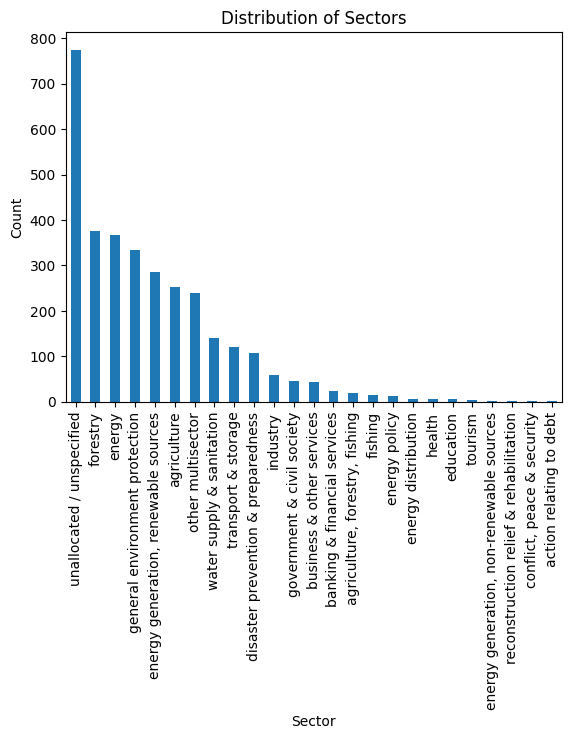

In [123]:
df_encoded['Sector (OECD)'].value_counts().plot(kind='bar')
plt.title('Distribution of Sectors')
plt.xlabel('Sector')
plt.ylabel('Count')
plt.show()

Here, we can see that 'Unallocated / unspecified' has the highest frequency, consisting about 20% of the dataset. Analysing the data, most of these values actually can not be categorised and can be referred to as 'other' and they are indeed not null values. Therefore, we can treat it like a category. The frequency significantly drops after 'unallocated / unspecified' followed by forestry, energty etc.

In [124]:
df_encoded.describe()

,Income Classification,Approved year,Grant,Amount of Funding Approved (USD millions),Fund Type_multi donor national,Fund Type_multi donor regional,Fund Type_multilateral,World Bank Region_east asia & pacific,World Bank Region_europe & central asia,World Bank Region_latin america & caribbean,World Bank Region_middle east & north africa,World Bank Region_not applicable,World Bank Region_south asia,World Bank Region_sub-saharan africa,World Bank Region_western asia,Theme/Objective_adaptation,Theme/Objective_mitigation - general,Theme/Objective_mitigation - redd,Theme/Objective_multiple foci
count,3240.000000,3240.000000,3.240000e+03,3.240000e+03,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000
mean,1.558951,2015.816358,2.193033e-17,4.386066e-17,0.031481,0.019444,0.949074,0.167901,0.088889,0.237963,0.050926,0.056481,0.077160,0.320062,0.000617,0.306790,0.296605,0.105247,0.291358
std,1.328290,4.248013,1.000154e+00,1.000154e+00,0.174642,0.138102,0.219880,0.373836,0.284627,0.425902,0.219880,0.230885,0.266887,0.466572,0.024841,0.461233,0.456831,0.306919,0.454458
min,0.000000,2003.000000,-4.565838e-01,-3.770241e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2013.000000,-4.130695e-01,-3.485062e-01,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2017.000000,-2.710322e-01,-2.573091e-01,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,2019.000000,4.116260e-02,-5.486184e-02,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,4.000000,2022.000000,2.478090e+01,1.485943e+01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [125]:
def plot(feature):
    df[feature].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

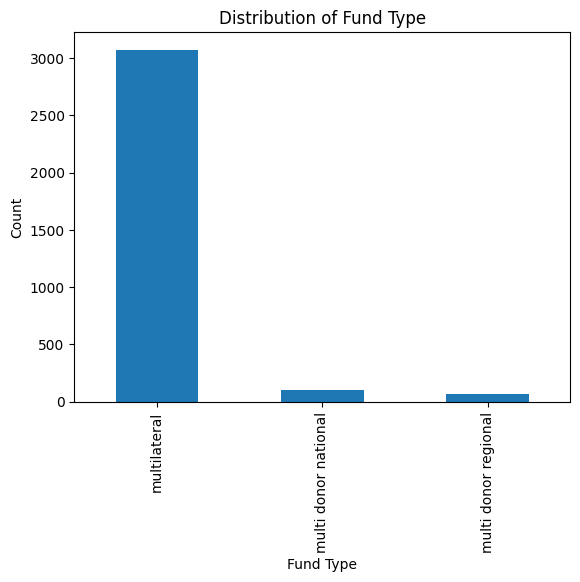

In [126]:
plot('Fund Type')

This chart shows that majority of the projects are done by multiple countries and very few of them are done by a specific region.

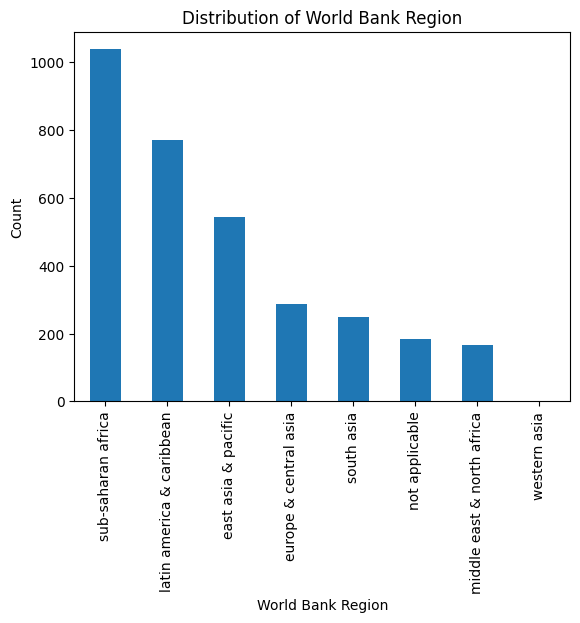

In [127]:
plot('World Bank Region')

Here, we can see that some regions have more projects than others. Sub-Saharan Africa and Latin America & Caribbean have higher counts, which could reflect a focus on these regions in terms of funding and projects. In contrast, regions such as Middle East & North Africa and Western Asia have fewer projects, which might be due to less funding and smaller focus from the World Bank.

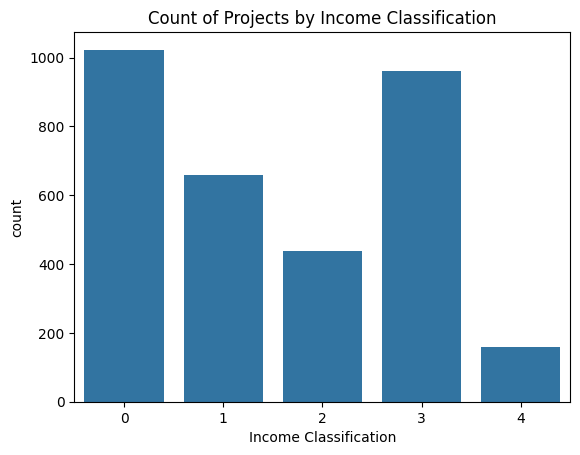

In [128]:
sns.countplot(x='Income Classification', data=df, order=[0, 1, 2, 3, 4])
plt.title('Count of Projects by Income Classification')
plt.show()

In [129]:
category_map

{'lower middle income': 0,
 'low income': 1,
 'not applicable': 2,
 'upper middle income': 3,
 'high income': 4}

Here, 0, meaning lower middle income countries have the most projects, which locates in sub-saharan africa, followed by upper middle income countries. Surprisingly, high income countries have the least number of projects.

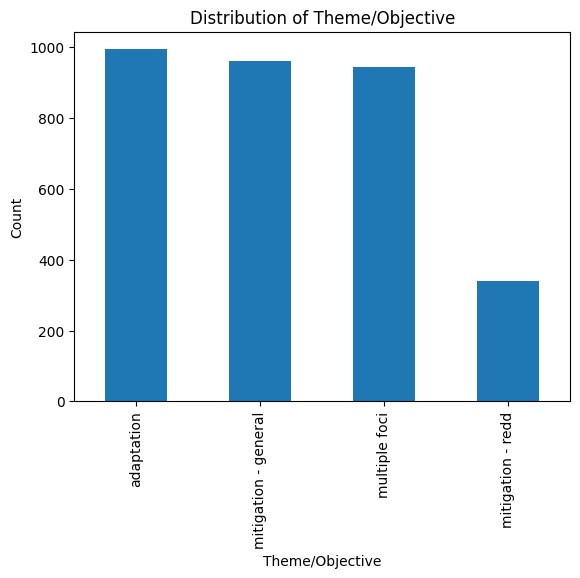

In [130]:
plot('Theme/Objective')

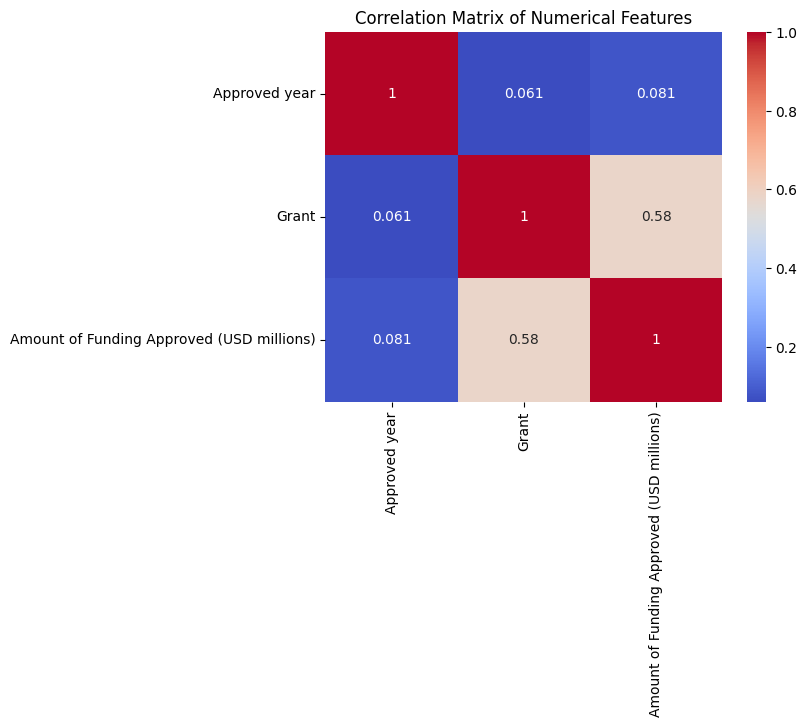

In [131]:
correlation_matrix = df_encoded[['Approved year', 'Grant', 'Amount of Funding Approved (USD millions)']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

Based on the correlation matrix above, we can say that there is not a linear correlation between approved year and grant or approved year and amount of funding approved, which suggests that the grant and amound of funding did not grow or decrease throughout the years. Additionally, there is a moderate positive correlation between the grant and the amount of funding, suggesting that as the grant grows, so does the amount of funding approved. However, since the correlation is not moderate, there is no concern for multicollinearity.

For clustering, we have to vectorise the text, and then choose an optimal k for the KMeans clustering method, using th eelbow method.

In [132]:
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.5, ngram_range=(1, 2))
text_tfidf = tfidf_vectorizer.fit_transform(df_encoded['Name of Project'])

processedData = text_tfidf.toarray()

Applying PCA:

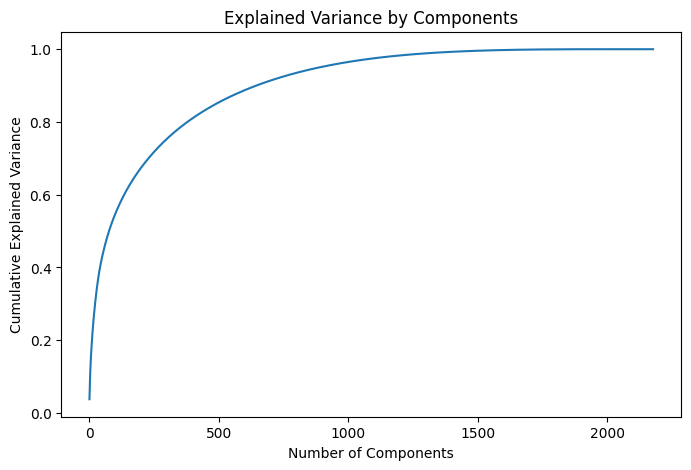

In [133]:
pca = PCA().fit(processedData)
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.show()

Here, we will choose the number of components as 500. Since it is a text data, it is normal to have large number of components. Taking it as 500 will reduce the dimensionality while keeping as much data as possible.

In [134]:
pca = PCA(n_components=500)
data_pca = pca.fit_transform(processedData)

In [135]:
silhouette_scores = []
for k in range(2, 21): 
    km = KMeans(n_clusters=k, random_state=17)
    preds = km.fit_predict(data_pca)
    score = silhouette_score(data_pca, preds)
    silhouette_scores.append(score)
    print(f'For k={k} the silhouette score is {score}')


For k=2 the silhouette score is 0.030544016722046676
For k=3 the silhouette score is 0.04310476382750866
For k=4 the silhouette score is 0.05491844726471072
For k=5 the silhouette score is 0.05617181589356117
For k=6 the silhouette score is 0.06307959330523703
For k=7 the silhouette score is 0.06887898942776834
For k=8 the silhouette score is 0.07346243732925653
For k=9 the silhouette score is 0.08730594515114976
For k=10 the silhouette score is 0.08143881757852096
For k=11 the silhouette score is 0.08099226294495585
For k=12 the silhouette score is 0.08151696530357125
For k=13 the silhouette score is 0.08625867183317658
For k=14 the silhouette score is 0.09201776131335408
For k=15 the silhouette score is 0.09105501913439056
For k=16 the silhouette score is 0.1024189434198744
For k=17 the silhouette score is 0.10576322670785822
For k=18 the silhouette score is 0.10495265676107285
For k=19 the silhouette score is 0.1113091958599332
For k=20 the silhouette score is 0.11315545422160517


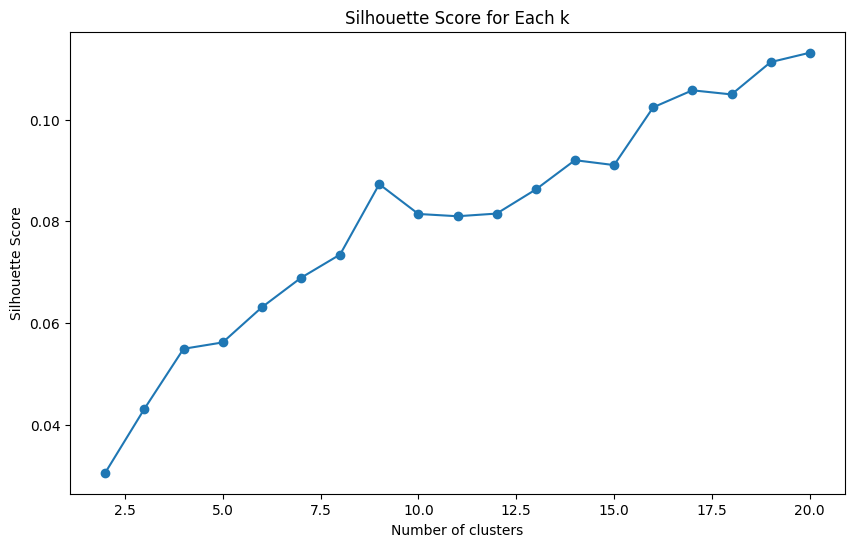

In [136]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 21), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Each k')
plt.show()

Based on the Silhouette scores, we can see that the overall scores are very low, which is common for text data with high dimensionality. As an optimal number we will choose 19, that gave us the best result

In [137]:
optimal_k = 19
km_optimal = KMeans(n_clusters=optimal_k, random_state=17)
km_optimal.fit(processedData)
clusters = km_optimal.labels_

## Step 4: Predictive Modelling

In [138]:
tfidf_df = pd.DataFrame(processedData)

df_encoded.reset_index(drop=True, inplace=True)

x = pd.concat([df_encoded.drop(columns=['Sector (OECD)', 'Name of Project']), tfidf_df], axis=1)

x.columns = x.columns.astype(str)

y = df_encoded['Sector (OECD)'].values

train_x, temp_x, train_y, temp_y = train_test_split(x, y, test_size=0.3, random_state=17)
val_x, test_x, val_y, test_y = train_test_split(temp_x, temp_y, test_size=0.5, random_state=17)

KNN classification:

Text(0.5, 1.0, 'Elbow Curve for test')

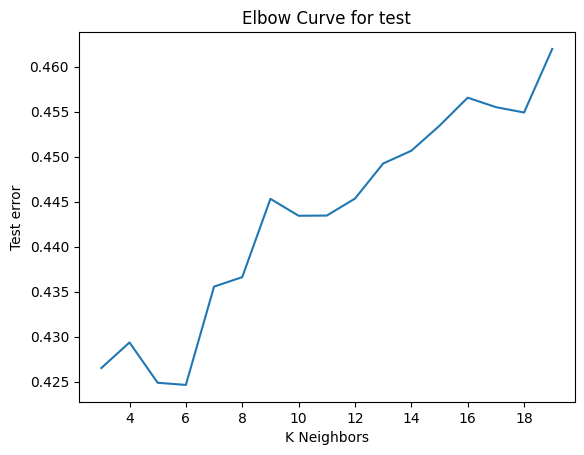

In [139]:
def Elbow(K):
    test_error = []
   
    for i in K:
        knn = KNN(n_neighbors = i)

        scores = cross_val_score(knn, train_x, train_y, cv=5, scoring='f1_weighted')
        test_error.append(1 - scores.mean())
    
    return test_error

k = range(3, 20, 1)
test = Elbow(k)

plt.plot(k, test)
plt.xlabel('K Neighbors')
plt.ylabel('Test error')
plt.title('Elbow Curve for test')

According to the elbow curve, the most optimal k is 6, with the lowest error.

In [140]:
optimal_k = 6
knn = KNN(n_neighbors=optimal_k)

knn_cv_scores = cross_val_score(knn, train_x, train_y, cv=10)
knn_cv_accuracy = knn_cv_scores.mean()

knn.fit(train_x, train_y)

print("Accuracy: ", knn_cv_accuracy)

Accuracy:  0.5965693345288682


Logistic regression:

In [141]:
lr = LogisticRegression(random_state=17)
lr_cv_scores = cross_val_score(lr, train_x, train_y, cv=10)
lr_cv_accuracy = lr_cv_scores.mean()

lr.fit(train_x, train_y)

print("Accuracy: ", lr_cv_accuracy)

Accuracy:  0.5132392499317765


Decision trees:

In [142]:
dt_classifier = DecisionTreeClassifier(random_state=17, max_depth=10)
dt_classifier.fit(train_x, train_y)

dt_cv_scores = cross_val_score(dt_classifier, train_x, train_y, cv=10, scoring='f1_weighted')

dt_cv_accuracy = dt_cv_scores.mean()

print("Accuracy: ", dt_cv_accuracy)

Accuracy:  0.9308197659247199


# Step 5: Model Evaluation and Visualizations

## KNN classification evaluation:

In [143]:
test_predict_knn = knn.predict(test_x)
print(classification_report(test_y, test_predict_knn))


                                          precision    recall  f1-score   support

                             agriculture       0.42      0.66      0.51        35
          agriculture, forestry, fishing       0.00      0.00      0.00         3
            banking & financial services       0.00      0.00      0.00         1
               business & other services       0.29      0.25      0.27         8
      disaster prevention & preparedness       0.29      0.24      0.26        17
                                  energy       0.45      0.73      0.56        55
                     energy distribution       0.00      0.00      0.00         3
energy generation, non-renewable sources       0.00      0.00      0.00         1
    energy generation, renewable sources       0.63      0.52      0.57        42
                           energy policy       0.00      0.00      0.00         1
                                 fishing       0.00      0.00      0.00         1
               

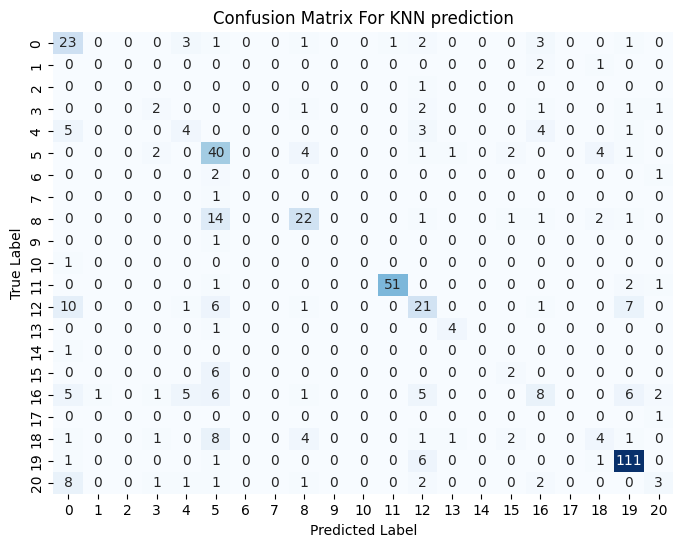

In [144]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(test_y, test_predict_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix For KNN prediction')
plt.show()


## Logistic Regression evaluation:

In [145]:
test_predict_lr = lr.predict(test_x)
print(classification_report(test_y, test_predict_lr))

                                          precision    recall  f1-score   support

                             agriculture       0.36      0.63      0.46        35
          agriculture, forestry, fishing       0.00      0.00      0.00         3
            banking & financial services       0.00      0.00      0.00         1
               business & other services       0.00      0.00      0.00         8
      disaster prevention & preparedness       0.00      0.00      0.00        17
                                  energy       0.39      0.84      0.53        55
                     energy distribution       0.00      0.00      0.00         3
energy generation, non-renewable sources       0.00      0.00      0.00         1
    energy generation, renewable sources       0.62      0.19      0.29        42
                           energy policy       0.00      0.00      0.00         1
                                 fishing       0.00      0.00      0.00         1
               

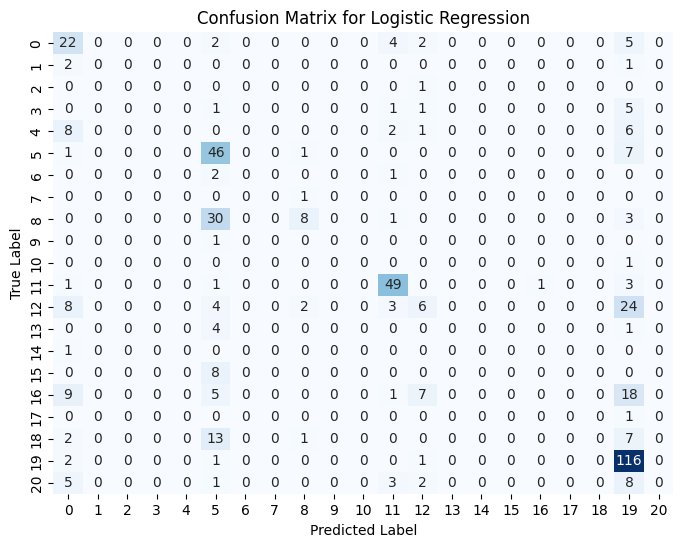

In [146]:
conf_matrix_lr = confusion_matrix(test_y, test_predict_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

## Decision trees evaluation:

In [155]:
test_predict_dt = dt_classifier.predict(test_x)

print(classification_report(test_y, test_predict_dt))


                                          precision    recall  f1-score   support

                             agriculture       1.00      1.00      1.00        35
          agriculture, forestry, fishing       0.00      0.00      0.00         3
            banking & financial services       0.00      0.00      0.00         1
               business & other services       0.00      0.00      0.00         8
      disaster prevention & preparedness       1.00      1.00      1.00        17
                                  energy       1.00      1.00      1.00        55
                     energy distribution       0.00      0.00      0.00         3
energy generation, non-renewable sources       0.00      0.00      0.00         1
    energy generation, renewable sources       1.00      1.00      1.00        42
                           energy policy       0.00      0.00      0.00         1
                                 fishing       0.00      0.00      0.00         1
               

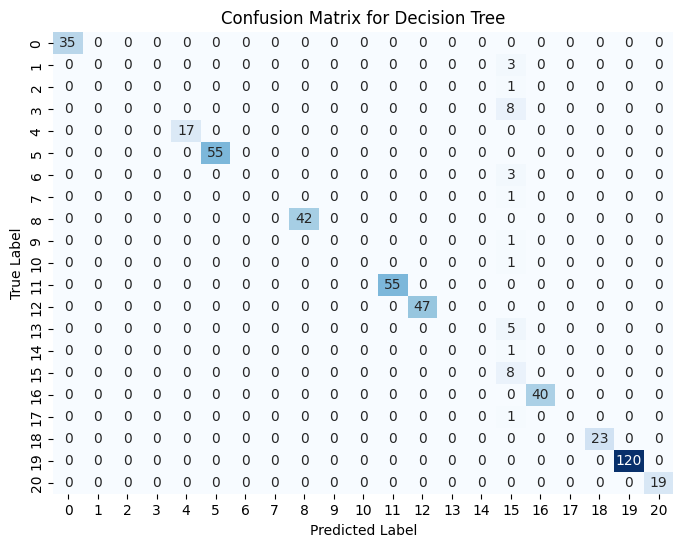

In [148]:
conf_matrix_dt = confusion_matrix(test_y, test_predict_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

Based on the stats and the confusion matrices, the best model appears to be the decision tree.
But we need to make sure it's not overfitted considering how high the accuracy and recall are.

In [149]:
from sklearn.model_selection import cross_val_predict
predicted_labels = cross_val_predict(dt_classifier, test_x, test_y, cv=10)
classification_rep2 = classification_report(test_y, predicted_labels)
print(classification_rep2)



                                          precision    recall  f1-score   support

                             agriculture       1.00      1.00      1.00        35
          agriculture, forestry, fishing       0.00      0.00      0.00         3
            banking & financial services       0.00      0.00      0.00         1
               business & other services       0.24      1.00      0.39         8
      disaster prevention & preparedness       1.00      1.00      1.00        17
                                  energy       1.00      1.00      1.00        55
                     energy distribution       0.00      0.00      0.00         3
energy generation, non-renewable sources       0.00      0.00      0.00         1
    energy generation, renewable sources       1.00      1.00      1.00        42
                           energy policy       0.00      0.00      0.00         1
                                 fishing       0.00      0.00      0.00         1
               

Since the accuracy and precision are high on all folds, then we can assume that we don't have an overfit model, and that the best prediction algorithm is the decision tree.